In [1]:
# Standard libraries
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from statsmodels.tsa.vector_ar.var_model import VAR
import scipy.optimize

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_neuro_perf
from matlab.matlab_lib import loadmat
from qt_wrapper import gui_fpath
from autoregression_lib import AR_MLE, AR_PREDICT

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/TNU2019-Project/src/lib


## 0. Loading data

In [4]:
# # Read LVM file from command line
# #data_path = gui_fpath("Select data directory", './')
# data_path = '../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour'
# data, behaviour = read_neuro_perf(data_path)

# # Get parameters
# nTrials, nTimes, nChannels = data.shape
# print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

# Read LVM file from command line
#filepath_h5 = gui_fname("Select data directory", './', filter='HDF5 files (*.h5)')
data_path = '../../data/intermediate/packageNeuroBehavioural.h5'
h5f = h5py.File(data_path, 'r')
dataAll = np.copy(h5f['megadata'])
h5f.close()

dataNeuro = dataAll[:,:,:12]
dataBehaviour = dataAll[:,:,12:]

nTrials, nTimes, nChannels = dataNeuro.shape
nBehaviourVar = dataBehaviour.shape[2]

print("Loaded neuronal data with (nTrials, nTimes, nChannels) =", dataNeuro.shape, "; behaviour variables", nBehaviourVar)

Loaded neuronal data with (nTrials, nTimes, nChannels) = (590, 161, 12) ; behaviour variables 6


## Naive Multivariate Autoregression Model

The autoregressive process of order $p$ is given by

$$X_i(t) = \sum_{jk} A^j_{ik} X_k(t-j) + \epsilon_i$$

In [5]:
PMAX = 7

dataTP = dataNeuro.transpose((2,0,1))
print("Unfitted residual ", np.linalg.norm(dataTP)**2)

LR_lst = []
A_lst_lst = []
for p in range(1,PMAX+1):
    A_lst = AR_MLE(dataTP, p)
    dataPred = AR_PREDICT(dataTP, p, A_lst)
    residual = dataTP[:,:,p:] - dataPred
    L2 = np.linalg.norm(residual)**2
    var = np.var(dataTP)
    LR_lst += [L2/var]
    A_lst_lst += [A_lst]
    
    print("For order",p,"residual is", L2, "log-likelihood-ratio", L2/var)

Unfitted residual  1139880.0000000002
For order 1 residual is 185969.0174149381 log-likelihood-ratio 185969.01741493802
For order 2 residual is 181892.89027947205 log-likelihood-ratio 181892.89027947196
For order 3 residual is 177111.07373690716 log-likelihood-ratio 177111.07373690707
For order 4 residual is 174433.15083073892 log-likelihood-ratio 174433.15083073883
For order 5 residual is 172143.13783167757 log-likelihood-ratio 172143.13783167748
For order 6 residual is 170223.78592237365 log-likelihood-ratio 170223.78592237356
For order 7 residual is 168570.2440017907 log-likelihood-ratio 168570.24400179062


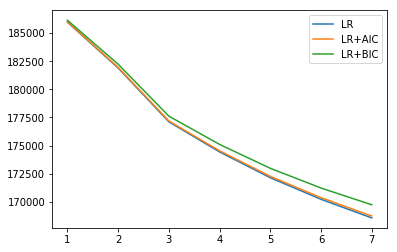

In [6]:
################################
#  Compute Fitness Criteria
################################

parr = np.linspace(1, PMAX, PMAX)
AIC = 2 * nChannels * parr
N_DATAPOINTS = nTrials  * nChannels * (nTimes - parr)
BIC = AIC / 2 * np.log(N_DATAPOINTS)

LR_arr = np.array(LR_lst)

plt.figure()
plt.plot(parr, LR_arr, label="LR")
plt.plot(parr, LR_arr+AIC, label="LR+AIC")
plt.plot(parr, LR_arr+BIC, label="LR+BIC")
plt.legend()
plt.show()

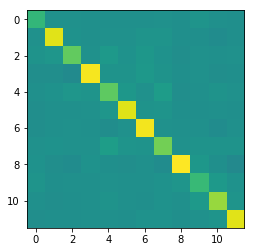

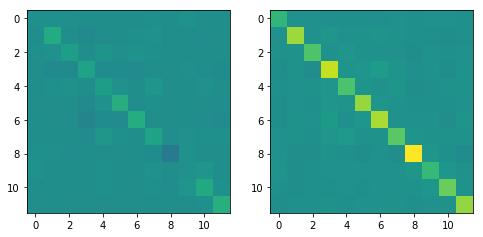

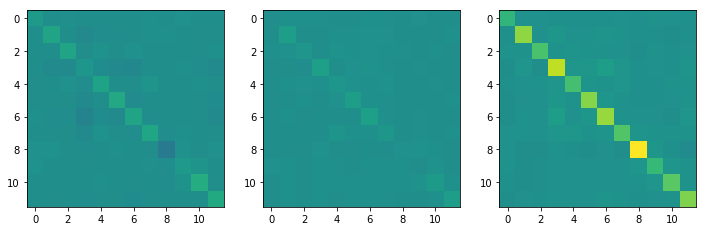

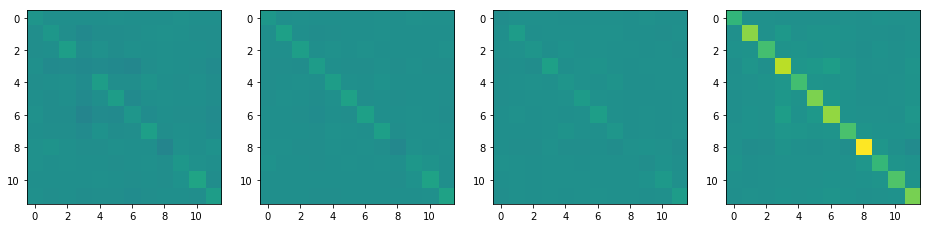

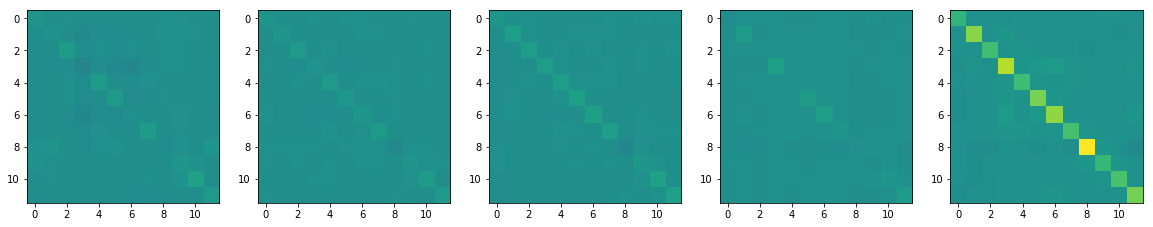

In [30]:
for p in range(5):
    A_lst = A_lst_lst[p]
    N_PLOT = len(A_lst)
    fig, ax = plt.subplots(ncols=N_PLOT, figsize=(4*N_PLOT, 4), squeeze=False)
    for i in range(N_PLOT):
        ax[0, i].imshow(A_lst[i], vmin = -1, vmax=1)
plt.show()

# plt.figure()
# plt.imshow(A_lst[0])
# plt.show()

# pd.DataFrame(A_lst[0])

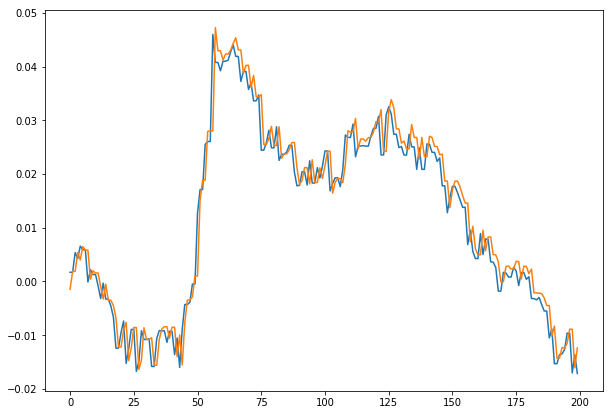

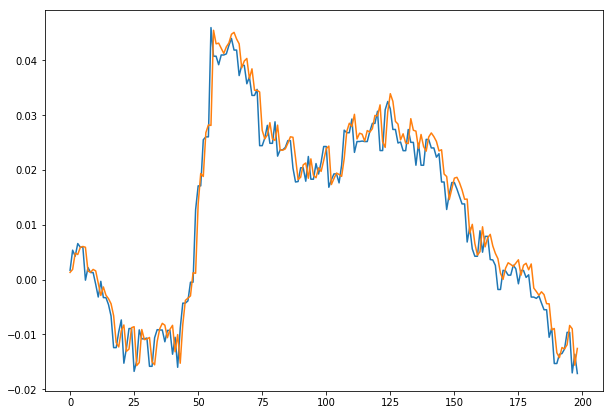

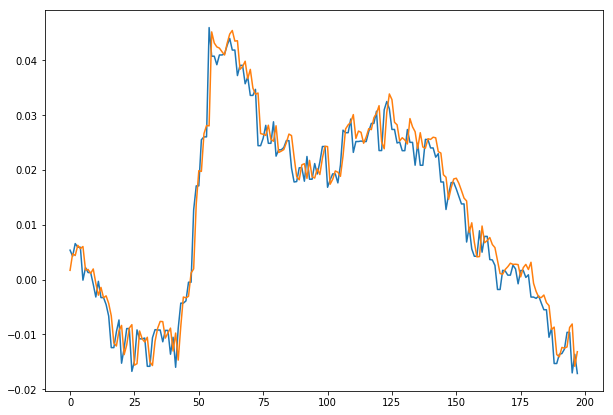

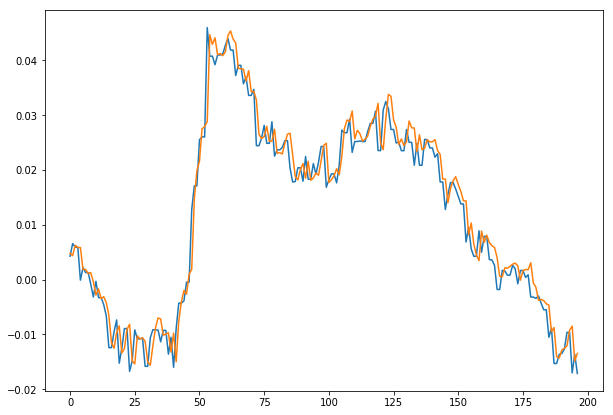

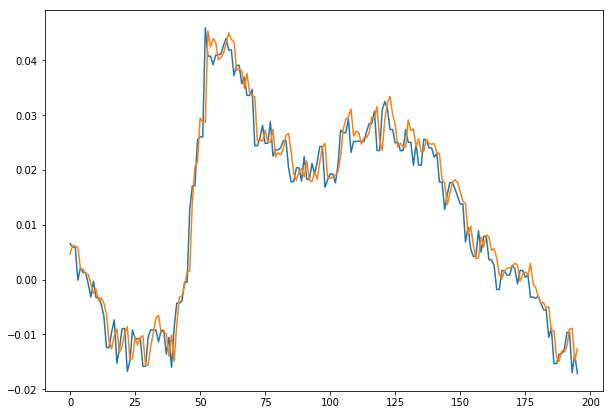

In [48]:
EXAMPLE_TRIAL = 10
EXAMPLE_CHANNEL = 3

for p in range(5):
    A_lst = A_lst_lst[p]
    dataPred = AR_PREDICT(dataTP, p+1, A_lst)

    plt.figure(figsize = (10, 7))
    plt.plot(dataTP[EXAMPLE_CHANNEL, EXAMPLE_TRIAL, p+1:])
    plt.plot(dataPred[EXAMPLE_CHANNEL, EXAMPLE_TRIAL, :])
    plt.show()
    
plt.show()